In [1]:
import datasets
from transformers import BertForSequenceClassification, BertModel, BertTokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import numpy as np
import torch

/usr/lib/python3/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-24 23:17:30.418170: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 23:17:31.323612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load and Analyze Data

In [2]:
data = datasets.load_dataset("tweet_eval", "sentiment")
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}

### Plotting label distribution of the splits.

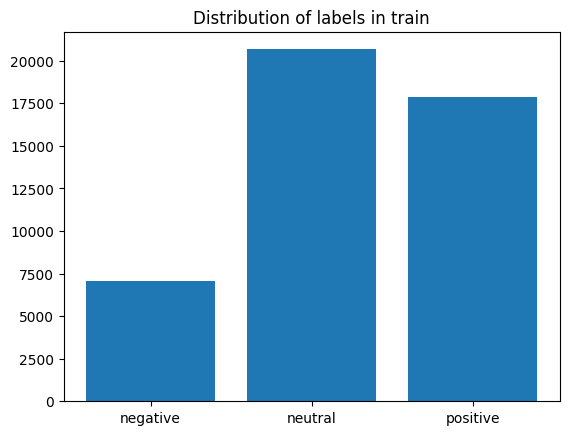

train [7093, 20673, 17849]


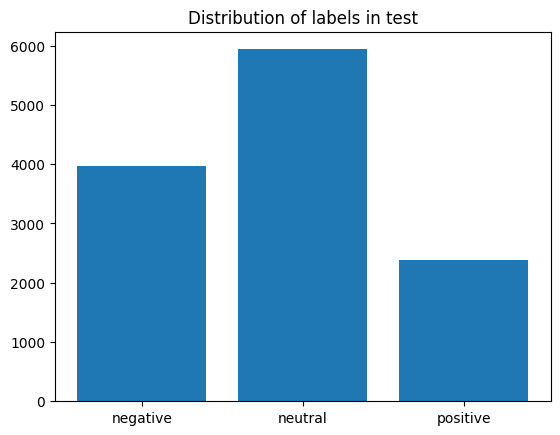

test [3972, 5937, 2375]


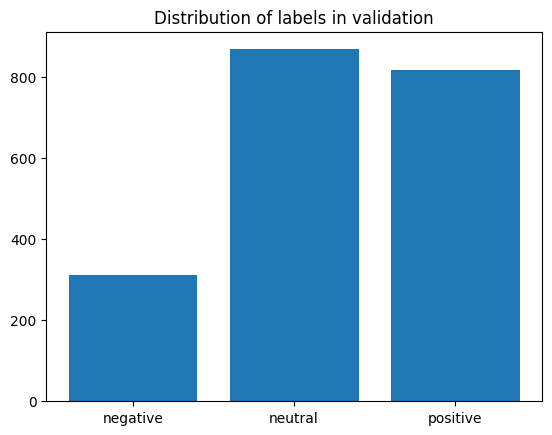

validation [312, 869, 819]


In [4]:
splits = ['train', 'test', 'validation']
#split = splits[2]

def plot_distr(split):
    fig = plt.figure()
    label_counts = data[split]['label']
    label_counts = [label_counts.count(i) for i in range(3)]
    plt.bar(['negative', 'neutral', 'positive'], label_counts)
    plt.title('Distribution of labels in ' + split)
    plt.show()

    print(split, label_counts)
    
for s in splits:
    plot_distr(s)

### Get splits

In [5]:
X_train, y_train = data['train']['text'], data['train']['label']
X_val, y_val = data['validation']['text'], data['validation']['label']
X_test, y_test = data['test']['text'], data['test']['label']

### Downsampling the splits

In [6]:
def down_sample(X, y):
    label_count = [y.count(i) for i in range(3)]
    min_count = min(label_count)
    
    XY = np.array(list(zip(X, y)))
    
    downsampled = []
    for i in range(3):
        label = XY[XY[:, 1] == str(i)]
        np.random.shuffle(label)
        downsampled.append(label[:min_count])
    
    downsampled = np.concatenate(downsampled)
    np.random.shuffle(downsampled)
    
    return list(downsampled[:, 0]), [int(x) for x in downsampled[:, 1]]

In [7]:
X_train_sample, y_train_sample = down_sample(X_train, y_train)
X_val_sample, y_val_sample = down_sample(X_val, y_val)
X_test_sample, y_test_sample = down_sample(X_test, y_test)

### Plot label distributions after downsampling

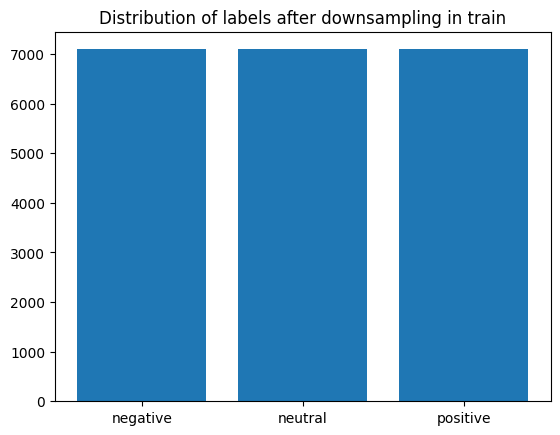

train [7093, 7093, 7093]


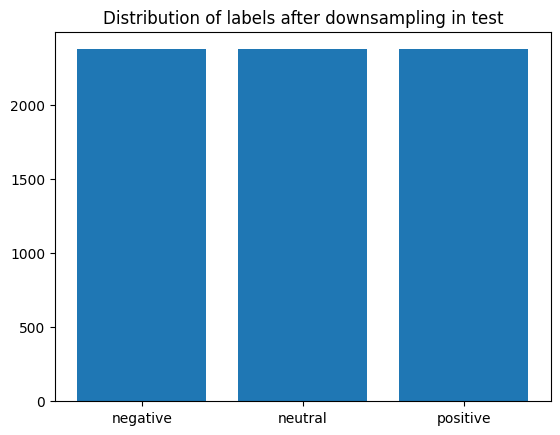

test [2375, 2375, 2375]


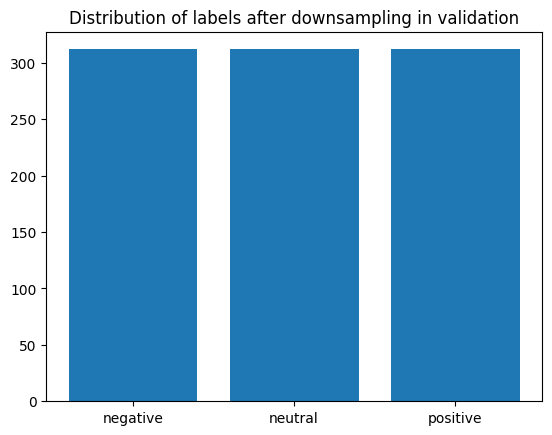

validation [312, 312, 312]


In [8]:
def plot_distr_sample(X, y, split):
    fig = plt.figure()
    label_counts = y
    label_counts = [label_counts.count(i) for i in range(3)]
    plt.bar(['negative', 'neutral', 'positive'], label_counts)
    plt.title('Distribution of labels after downsampling in ' + split)
    plt.show()

    print(split, label_counts)
    
plot_distr_sample(X_train_sample, y_train_sample, 'train')
plot_distr_sample(X_test_sample, y_test_sample, 'test')
plot_distr_sample(X_val_sample, y_val_sample, 'validation')


## Finetune BERT Model

### Initialize the model

In [9]:
bertsc = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


train_encodings = tokenizer(X_train_sample, truncation=True, padding=True)
val_encodings = tokenizer(X_val_sample, truncation=True, padding=True)
test_encodings = tokenizer(X_test_sample, truncation=True, padding=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Prepare data and metrics

In [10]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = TweetDataset(train_encodings, y_train_sample)
val_dataset = TweetDataset(val_encodings, y_val_sample)
test_dataset = TweetDataset(test_encodings, y_test_sample)

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def _compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='macro')
    acc = accuracy_score(labels, pred)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

### Training

In [12]:
train_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./results/logs',
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    fp16=True
    
)

trainer = Trainer(
    model=bertsc,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=_compute_metrics
)

trainer.train()

 20%|██        | 2660/13300 [08:30<32:04,  5.53it/s]

{'loss': 0.8028, 'grad_norm': 10.687106132507324, 'learning_rate': 4.1574218750000006e-05, 'epoch': 1.0}


                                                    
 20%|██        | 2660/13300 [08:34<32:04,  5.53it/s]

{'eval_loss': 0.702452540397644, 'eval_accuracy': 0.6987179487179487, 'eval_f1': 0.6922299641525091, 'eval_precision': 0.7028864956366926, 'eval_recall': 0.6987179487179486, 'eval_runtime': 3.4708, 'eval_samples_per_second': 269.68, 'eval_steps_per_second': 33.71, 'epoch': 1.0}


 40%|████      | 5320/13300 [18:02<25:13,  5.27it/s]   

{'loss': 0.5716, 'grad_norm': 5.3195366859436035, 'learning_rate': 3.1187500000000006e-05, 'epoch': 2.0}


                                                    
 40%|████      | 5320/13300 [18:06<25:13,  5.27it/s]

{'eval_loss': 0.7472838163375854, 'eval_accuracy': 0.7222222222222222, 'eval_f1': 0.7164489882119476, 'eval_precision': 0.7225400479859521, 'eval_recall': 0.7222222222222222, 'eval_runtime': 3.7455, 'eval_samples_per_second': 249.903, 'eval_steps_per_second': 31.238, 'epoch': 2.0}


 60%|██████    | 7980/13300 [29:36<14:20,  6.18it/s]  

{'loss': 0.3833, 'grad_norm': 2.2687463760375977, 'learning_rate': 2.08046875e-05, 'epoch': 3.0}


                                                    
 60%|██████    | 7980/13300 [29:39<14:20,  6.18it/s]

{'eval_loss': 0.915777862071991, 'eval_accuracy': 0.7061965811965812, 'eval_f1': 0.7045269850012588, 'eval_precision': 0.7045171908845628, 'eval_recall': 0.7061965811965812, 'eval_runtime': 3.0216, 'eval_samples_per_second': 309.767, 'eval_steps_per_second': 38.721, 'epoch': 3.0}


 80%|████████  | 10640/13300 [36:53<06:53,  6.43it/s] 

{'loss': 0.2383, 'grad_norm': 15.6503324508667, 'learning_rate': 1.0421875000000001e-05, 'epoch': 4.0}


                                                     
 80%|████████  | 10640/13300 [36:55<06:53,  6.43it/s]

{'eval_loss': 1.407274842262268, 'eval_accuracy': 0.7115384615384616, 'eval_f1': 0.7109285604746786, 'eval_precision': 0.7105790348327264, 'eval_recall': 0.7115384615384616, 'eval_runtime': 2.7786, 'eval_samples_per_second': 336.857, 'eval_steps_per_second': 42.107, 'epoch': 4.0}


100%|██████████| 13300/13300 [44:04<00:00,  6.49it/s]  

{'loss': 0.1263, 'grad_norm': 0.04645097628235817, 'learning_rate': 3.515625e-08, 'epoch': 5.0}


                                                     
100%|██████████| 13300/13300 [44:07<00:00,  6.49it/s]

{'eval_loss': 1.7510933876037598, 'eval_accuracy': 0.6997863247863247, 'eval_f1': 0.7011336426889456, 'eval_precision': 0.7043087583697852, 'eval_recall': 0.6997863247863249, 'eval_runtime': 2.7526, 'eval_samples_per_second': 340.048, 'eval_steps_per_second': 42.506, 'epoch': 5.0}


100%|██████████| 13300/13300 [44:16<00:00,  5.01it/s]

{'train_runtime': 2656.0418, 'train_samples_per_second': 40.058, 'train_steps_per_second': 5.007, 'train_loss': 0.42446046986974273, 'epoch': 5.0}


TrainOutput(global_step=13300, training_loss=0.42446046986974273, metrics={'train_runtime': 2656.0418, 'train_samples_per_second': 40.058, 'train_steps_per_second': 5.007, 'total_flos': 5904974266700040.0, 'train_loss': 0.42446046986974273, 'epoch': 5.0})

### Plot training and validation metrics

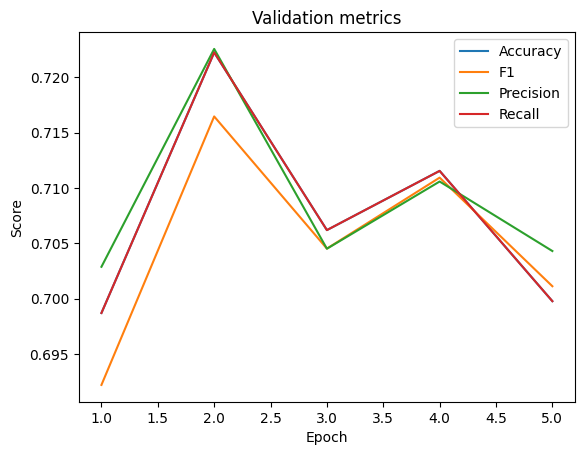

In [37]:
log_metrics = trainer.state.log_history
val_metrics = [log_metrics[i] for i in range(len(log_metrics)) if i % 2 == 1][:int(log_metrics[-1]['epoch'])]

val_acc = [m['eval_accuracy'] for m in val_metrics]
val_f1 = [m['eval_f1'] for m in val_metrics]
val_precision = [m['eval_precision'] for m in val_metrics]
val_recall = [m['eval_recall'] for m in val_metrics]
val_loss = [m['eval_loss'] for m in val_metrics]

fig, ax = plt.subplots()

epochs = np.arange(1, len(val_acc) + 1)

ax.plot(epochs, val_acc, label='Accuracy')
ax.plot(epochs, val_f1, label='F1')
ax.plot(epochs, val_precision, label='Precision')
ax.plot(epochs, val_recall, label='Recall')

ax.set_xlabel('Epoch')
ax.set_ylabel('Score')
ax.set_title('Validation metrics')
ax.legend()
plt.show()

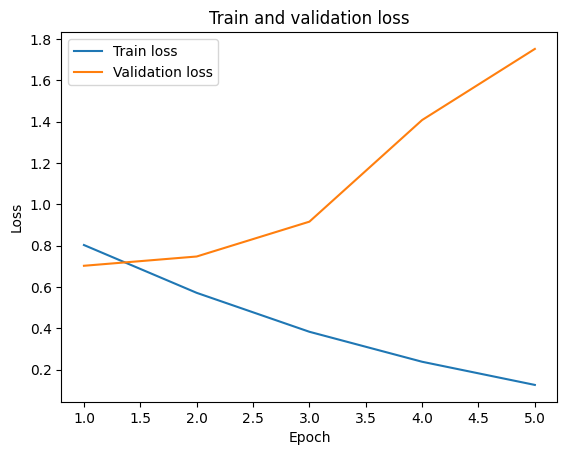

In [40]:
train_metrics = [log_metrics[i] for i in range(len(log_metrics)) if i % 2 == 0][:-1]

train_loss = [m['loss'] for m in train_metrics]

epochs = np.arange(1, len(val_acc) + 1)

fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label='Train loss')
ax.plot(epochs, val_loss, label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train and validation loss')
ax.legend()
plt.show()

## Load best BERT model

In [ ]:
best_model = "checkpoint-5320" # Epoch = 2

### Test the model

In [44]:
best_bert = BertForSequenceClassification.from_pretrained('results/' + best_model)
# test on test set
predictions = trainer.predict(test_dataset)
predictions.metrics

test_acc = accuracy_score(y_test_sample, np.argmax(predictions.predictions, axis=1))
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test_sample, np.argmax(predictions.predictions, axis=1), average='macro')

print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test F1:', test_f1)

100%|██████████| 891/891 [00:23<00:00, 37.83it/s]

Test accuracy: 0.6680701754385965
Test precision: 0.6737024770843848
Test recall: 0.6680701754385966
Test F1: 0.6675729468334018


### Load as BERT Encoder

In [45]:
bert = BertModel.from_pretrained('results/' + best_model)

## Extract BERT embeddings for the dataset

In [59]:
import pandas as pd

def get_embeddings(model, dataset: TweetDataset, batch_size=16):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    embeddings = []
    i = 1
    for batch in loader:
        print(f'{i}/{len(loader)}', '\t'*3, end='\r')
        with torch.no_grad():
            batch.pop('labels')
            output = model(**batch)
            embeddings.append(output.last_hidden_state[:, 0, :].detach().numpy())
        i += 1
    print('\n\n')
    return np.concatenate(embeddings)

In [60]:
def save_emb_to_csv(emb, y, filename):
    df=pd.DataFrame(emb)
    df['label'] = y
    df.to_csv(filename, index=False)

print('Saving train embeddings...')
save_emb_to_csv(
    get_embeddings(bert, train_dataset),
    y_train_sample,
    'data/train_embeddings.csv'
)

print('Saving test embeddings...')
save_emb_to_csv(
    get_embeddings(bert, test_dataset),
    y_test_sample,
    'data/test_embeddings.csv'
)

print('Saving val embeddings...')
save_emb_to_csv(
    get_embeddings(bert, val_dataset),
    y_val_sample,
    'data/val_embeddings.csv'
)


Saving train embeddings...
1330/1330 			


Saving test embeddings...
446/446 			


Saving val embeddings...
59/59 			




## Load embeddings from CSV

In [61]:
train_emb = pd.read_csv('data/train_embeddings.csv')
test_emb = pd.read_csv('data/test_embeddings.csv')
val_emb = pd.read_csv('data/val_embeddings.csv')